# About

Ce notebook a pour objectif de créer une expérience Azure ML à partir des données tips issu du magasin blobstore de Azure

# Import des librairies nécessaires

In [12]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import azureml.core
from azureml.core import Workspace
from azureml.core.compute import ComputeTarget,AmlCompute
from azureml.core import Dataset

# 1- Connexion au workspace 

In [13]:
# Load the workspace from the saved config file
ws = Workspace.from_config("./config.json")
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.26.0 to work with moocazure


# 2- Creation d'un Groupe de Calcul

In [14]:
# Specify a name for the compute (unique within the workspace)
compute_name = "MoocAzure"

# Define compute configuration
compute_config = AmlCompute.provisioning_configuration(vm_size="standard_F2s_v2",min_nodes=0,max_nodes=4,vm_priority="dedicated")

# Create the compute
aml_cluster = ComputeTarget.create(ws,compute_name,compute_config)
aml_cluster.wait_for_completion(show_output=True)

SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# 3- Récupération des données

In [15]:
default_ds = ws.get_default_datastore()
print(default_ds)

{
  "name": "workspaceblobstore",
  "container_name": "azureml-blobstore-5af75a59-02d5-481a-ab9e-7ea0ffcab13a",
  "account_name": "moocazure8329289620",
  "protocol": "https",
  "endpoint": "core.windows.net"
}


In [16]:
datastore_paths = [(default_ds, './tips/tips.csv')]

tips_ds = Dataset.Tabular.from_delimited_files(path=datastore_paths)
tips_ds.take(3).to_pandas_dataframe()

total_bill   tip     sex  smoker  day    time  size
0       16.99  1.01  Female   False  Sun  Dinner     2
1       10.34  1.66    Male   False  Sun  Dinner     3
2       21.01  3.50    Male   False  Sun  Dinner     3

In [17]:
df = tips_ds.to_pandas_dataframe()
df

total_bill   tip     sex  smoker   day    time  size
0         16.99  1.01  Female   False   Sun  Dinner     2
1         10.34  1.66    Male   False   Sun  Dinner     3
2         21.01  3.50    Male   False   Sun  Dinner     3
3         23.68  3.31    Male   False   Sun  Dinner     2
4         24.59  3.61  Female   False   Sun  Dinner     4
..          ...   ...     ...     ...   ...     ...   ...
239       29.03  5.92    Male   False   Sat  Dinner     3
240       27.18  2.00  Female    True   Sat  Dinner     2
241       22.67  2.00    Male    True   Sat  Dinner     2
242       17.82  1.75    Male   False   Sat  Dinner     2
243       18.78  3.00  Female   False  Thur  Dinner     2

[244 rows x 7 columns]

In [18]:
df["time"].value_counts()

Dinner    176
Lunch      68
Name: time, dtype: int64

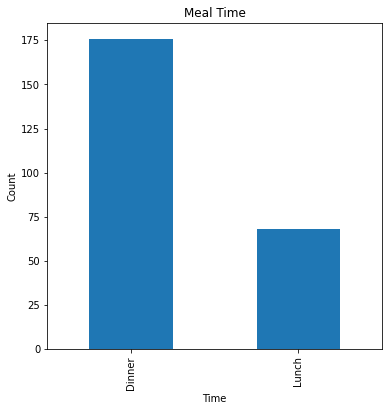

In [19]:
meal_time_count = df['time'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
meal_time_count.plot.bar(ax = ax) 
ax.set_title('Meal Time') 
ax.set_xlabel('Time') 
ax.set_ylabel('Count')
plt.show()

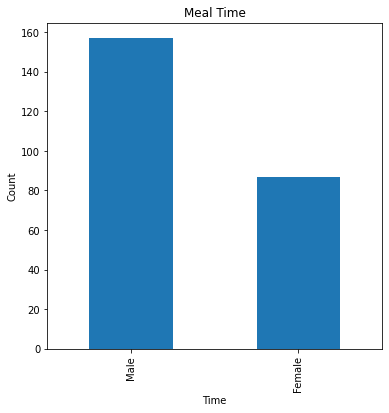

In [20]:
sex_count = df['sex'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
sex_count.plot.bar(ax = ax) 
ax.set_title('Meal Time') 
ax.set_xlabel('Time') 
ax.set_ylabel('Count')
plt.show()

# 3- Création de l'expérience

Starting experiment: tips_exp
Analyzing 244 rows of data


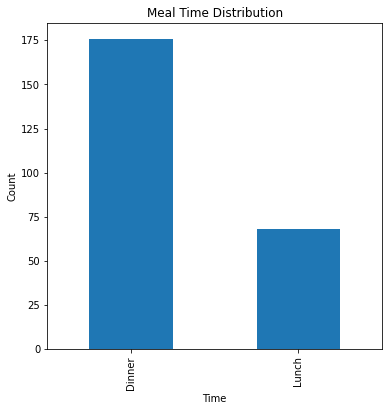

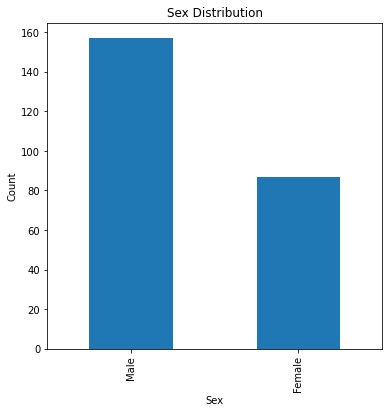

In [26]:
# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace=ws, name="tips_exp")

# Start logging data from the experiment, obtaining a reference to the experiment run
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

# Count the rows and log the result
row_count = (len(df))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Plot and log the count of DinnerTime vs LunchTime
meal_time_count = df['time'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
meal_time_count.plot.bar(ax = ax) 
ax.set_title('Meal Time Distribution') 
ax.set_xlabel('Time') 
ax.set_ylabel('Count')
plt.show()
run.log_image(name='MealTime distribution', plot=fig)

# Plot and log the count of Female vs Male
sex_count = df['sex'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
sex_count.plot.bar(ax = ax) 
ax.set_title('Sex Distribution') 
ax.set_xlabel('Sex') 
ax.set_ylabel('Count')
plt.show()
run.log_image(name='Sex distribution', plot=fig)

# Save a sample of the data and upload it to the experiment output
#df.sample(100).to_csv('outputs/tips_sample.csv', index=False, header=True)
#run.upload_file(name='outputs/tips_sample.csv', path_or_stream='./tips_sample.csv')

# Complete the run
run.complete()

In [28]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…